In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import tqdm
sns.set_theme(style="darkgrid")

#Word2Vec
from langdetect import detect
import nltk
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import Word2Vec

#keras
import tensorflow as tf
import keras

In [2]:
%%bash
ls

LiteratureReport.pdf
main.ipynb
ml.ipynb
OLID
README.md
roberta.large
script.ipynb
second.ipynb
SOLID


In [3]:
# Load datasets and rename columns, load all aqi data but specify metro data name
def loadcsv():
    train = pd.read_csv('OLID/olid-training-v1.0.tsv',delimiter='\t',skiprows=1,header=None)
#     train.drop([3], axis = 1,inplace=True)
#     train.drop([4], axis = 1,inplace=True)
    train[2] = np.where(train[2]=="NOT",0,1)
    
    testlabel = pd.read_csv('OLID/labels-levela.csv',delimiter=',',header=None,dtype=str)
    testlabel.drop([0], axis = 1,inplace=True)
    testlabel.rename(columns={1: 2},inplace=True)
    
    testdata = pd.read_csv('OLID/testset-levela.tsv',delimiter='\t')
    print(testdata.columns) 
    
    test = pd.concat([testdata,testlabel], axis=1)
    test[2] = np.where(test[2]=="NOT",0,1)
    test.rename(columns={'id':0,'tweet':1},inplace=True)
    
    return train,test
train,test=loadcsv()

Index(['id', 'tweet'], dtype='object')


In [4]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    ## back to string from list
    text = " ".join(lst_text)
    return text
def processdf(df):
    df['tweet'] = df[1].apply(utils_preprocess_text)
    df['tweet'] = df['tweet'].apply(word_tokenize)
processdf(train)
processdf(test)
test

,0,1,2,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,1,"[whoisq, wherestheserver, dumpnike, declasfisa..."
1,27014,"#ConstitutionDay is revered by Conservatives, ...",0,"[constitutionday, is, revered, by, conservativ..."
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...,0,"[foxnews, nra, maga, potus, trump, 2ndamendmen..."
3,13876,#Watching #Boomer getting the news that she is...,0,"[watching, boomer, getting, the, news, that, s..."
4,60133,#NoPasaran: Unity demo to oppose the far-right...,1,"[nopasaran, unity, demo, to, oppose, the, farr..."
...,...,...,...,...
855,73439,#DespicableDems lie again about rifles. Dem Di...,1,"[despicabledems, lie, again, about, rifle, dem..."
856,25657,#MeetTheSpeakers 🙌 @USER will present in our e...,0,"[meetthespeakers, user, will, present, in, our..."
857,67018,3 people just unfollowed me for talking about ...,1,"[3, people, just, unfollowed, me, for, talking..."
858,50665,#WednesdayWisdom Antifa calls the right fascis...,0,"[wednesdaywisdom, antifa, call, the, right, fa..."


In [87]:
def getF1(confusion):
    numClass = confusion.shape[0]
    total = np.sum(np.sum(confusion))
    
    # get True positive from diagonals
    tp = confusion.diagonal().reshape((numClass,1)).copy()
    
    # make diagonal zeros
    confusionCopy = confusion.copy()
    np.fill_diagonal(confusionCopy,0)
    fn = np.sum(confusionCopy,axis=1).reshape(((numClass,1))).copy()
    fp = np.sum(confusionCopy,axis=0).reshape(((numClass,1))).copy()
    if(np.sum(tp+fp)==0 or np.isfinite(tp+fp).all()==False):
        print(tp,fp)
        prec = tp
    else:
        prec = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = (2*prec*recall) / (prec+recall)
    
    microPrec = np.sum(tp) / (np.sum(tp)+np.sum(fp))
    microRecall = np.sum(tp) / (np.sum(tp)+np.sum(fn))
    microf1 = (2*microPrec*microRecall) / (microPrec+microRecall)
    
    macroPrec = np.mean(prec)
    macroRecall = np.mean(recall)
    macrof1 = np.mean(f1)

    return [[microPrec,microRecall,microf1],[macroPrec,macroRecall,macrof1]]

def getConfusion(yTrue,yPred,numClass):
    yPred = np.where(yPred > 0.5, 1, 0)
    n=yTrue.shape[0]
    assert(yTrue.shape[0]==yPred.shape[0])
    confusion = np.zeros((numClass,numClass)).astype(int)
    for i in range(n):
        confusion[int(yTrue.item(i)),int(yPred.item(i))] +=1
    return confusion
def getAccuracy(confusion):
    total = np.sum(np.sum(confusion))
    tp = np.sum(confusion.diagonal())
    return (tp/total) * 100

In [133]:
def getLexicon1():
    d_emotion=pd.read_csv("./OLID/lexicons/5. NRC-Hashtag-Emotion-Lexicon-v0.2.txt", sep='\t', names=['emotion','word','score'], header=None)
    dic_dEmo={}
#     print(d_emotion)
    for i in range(len(d_emotion['word'])):
        if(type(d_emotion['word'][i]) == str):
            turncated = d_emotion['word'][i]
#             print(turncated)
            if(turncated[0]=='#'):
                turncated = turncated[1:]
            dic_dEmo[turncated]=d_emotion['score'][i]
    return dic_dEmo
def getLexicon2():
    d_emotion=pd.read_csv("./OLID/lexicons/6. NRC-10-expanded.csv", sep='\t')
    dic_dEmo={}
    for i in range(len(d_emotion['word'])):
        if(type(d_emotion['word'][i]) == str):
            turncated = d_emotion['word'][i]
            if(turncated[0]=='#'):
                turncated = turncated[1:]
            dic_dEmo[turncated]=d_emotion['anger'][i]
    return dic_dEmo
def getLexicon3():
    d_emotion=pd.read_csv("./OLID/lexicons/8. NRC-word-emotion-lexicon.txt", sep='\t', names=['word','emotion','score'], header=None)
#     print(d_emotion)
    dic_dEmo={}
    for i in range(len(d_emotion['word'])):
        if(type(d_emotion['word'][i]) == str):
            turncated = d_emotion['word'][i]
            if(turncated[0]=='#'):
                turncated = turncated[1:]
            dic_dEmo[turncated]=d_emotion['score'][i]
    return dic_dEmo
def getLexicon4():
    
lex3 = getLexicon3()
lex3

{'smut': 0,
 'expletive': 0,
 'nape': 0,
 'greeting': 0,
 'stereoscopic': 0,
 'measles': 0,
 'proven': 1,
 'inept': 0,
 'perverted': 0,
 'inconsequential': 0,
 'issue': 0,
 'narrator': 0,
 'pike': 0,
 'dwelling': 0,
 'distinguished': 0,
 'unfulfilled': 0,
 'sod': 0,
 'load': 0,
 'appliance': 0,
 'cinema': 0,
 'tantalizing': 0,
 'rotation': 0,
 'lynch': 0,
 'constrained': 0,
 'agitation': 0,
 'lumbar': 0,
 'omitted': 0,
 'sculptured': 0,
 'hash': 0,
 'ewe': 0,
 'trump': 0,
 'gray': 0,
 'inventor': 0,
 'supporters': 0,
 'felicity': 0,
 'privy': 1,
 'wrongdoing': 0,
 'satanic': 0,
 'militia': 0,
 'sess': 0,
 'corn': 0,
 'bellows': 0,
 'descend': 0,
 'sedan': 0,
 'motionless': 0,
 'civility': 0,
 'unite': 0,
 'synthetic': 0,
 'shorthand': 0,
 'jiffy': 0,
 'artistic': 0,
 'photograph': 0,
 'exercise': 0,
 'estranged': 0,
 'algebraic': 0,
 'metastasis': 0,
 'wait': 0,
 'haste': 0,
 'lunar': 0,
 'gruesome': 0,
 'pawn': 1,
 'favor': 0,
 'embezzlement': 0,
 'lovable': 1,
 'riverbank': 0,
 'rare

In [135]:
VECTOR_SIZE = 100
EXTRA_VECTORS = 3
PADDING_SIZE = 30

# def getEmbeddings(train,test):
corpus = pd.concat([train['tweet'],test['tweet']])
# print(len(train),len(test),len(corpus))
# vecmodel = gensim.models.word2vec.Word2Vec(corpus, size=VECTOR_SIZE,window=8, min_count=1, sg=1, iter=50)
tk=tf.keras.preprocessing.text.Tokenizer(lower=True,split=' ',oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tk.fit_on_texts(corpus)

train['tweet_id'] = tk.texts_to_sequences(train['tweet'])
test['tweet_id'] = tk.texts_to_sequences(test['tweet'])

Xtrain = tf.keras.preprocessing.sequence.pad_sequences(train['tweet_id'], maxlen=PADDING_SIZE,padding="post", truncating="post",value=0)
Xtest = tf.keras.preprocessing.sequence.pad_sequences(test['tweet_id'], maxlen=PADDING_SIZE,padding="post", truncating="post",value=0)

# print(tk.word_index)
# LEXICON FEATURES APPEND
dic1 = getLexicon1()
dic2 = getLexicon2()
dic3 = getLexicon3()
    
ytrain = np.array(train[2]).reshape((train[2].shape[0],1))
ytest = np.array(test[2]).reshape((test[2].shape[0],1))

embed = np.zeros((len(tk.word_index)+1, VECTOR_SIZE+EXTRA_VECTORS))
for word,idx in tk.word_index.items():
    if(word in vecmodel.wv):
#         embed[idx] = vecmodel.wv[word]
        lexiconVec = np.zeros(EXTRA_VECTORS)
        if(word in dic1):
            lexiconVec[0] = dic1[word]
        if(word in dic2):
            lexiconVec[1] = dic2[word]
        if(word in dic3):
            lexiconVec[2] = dic3[word]
        embed[idx] = np.concatenate((vecmodel.wv[word],lexiconVec))


print(vecmodel.wv[word].shape)
print(Xtrain.shape,Xtest.shape)
print(ytrain.shape,ytest.shape)
print(embed.shape)
embed
#     return Xtrain,Xtest,ytrain,ytest,embed

# Xtrain,Xtest,ytrain,ytest,embed = getEmbeddings(train,test)

(100,)
(13240, 30) (860, 30)
(13240, 1) (860, 1)
(20438, 103)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.26172853, -0.01655492,  0.18170634, ...,  0.7171036 ,
         0.00646391,  0.        ],
       ...,
       [-0.45530105,  0.15587123,  0.30992439, ...,  0.        ,
         0.        ,  0.        ],
       [-0.30029383,  0.22036591,  0.28825191, ...,  0.        ,
         0.        ,  0.        ],
       [-0.52317059,  0.13874973,  0.02804619, ...,  0.        ,
         0.        ,  0.        ]])

In [148]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Lambda
import keras.backend as kb

def channelPool(x):
    return kb.max(x,axis=-1)

def attention_layer(inputs, neurons):
    x = keras.layers.Permute((2,1))(inputs)
    x = keras.layers.Dense(neurons, activation="softmax")(x)
    x = keras.layers.Permute((2,1), name="attention")(x)
    x = keras.layers.multiply([inputs, x])
    return x

def trainModel1(Xtrain,Xtest,ytrain,ytest,embed):
    with tf.device('/CPU:0'):
        x_in = keras.layers.Input(shape=(PADDING_SIZE,))
        x = Embedding(input_dim=embed.shape[0],output_dim=embed.shape[1],weights=[embed],input_length=PADDING_SIZE,trainable=False)(x_in)

#         x = keras.layers.Permute((2,1))(x)

        x1 = Conv1D(50,2, activation='relu',input_shape=(PADDING_SIZE,VECTOR_SIZE+EXTRA_VECTORS),padding='same') (x)
#         x1 = MaxPooling1D(pool_size=2) (x1)
        
        x2 = Conv1D(50,3, activation='relu',input_shape=(PADDING_SIZE,VECTOR_SIZE+EXTRA_VECTORS),padding='same') (x)
#         x2 = MaxPooling1D(pool_size=2) (x2)

        x3 = Conv1D(50,4, activation='relu',input_shape=(PADDING_SIZE,VECTOR_SIZE+EXTRA_VECTORS),padding='same') (x)
#         x3 = MaxPooling1D(pool_size=2) (x3)
        
        x4 = Conv1D(50,5, activation='relu',input_shape=(PADDING_SIZE,VECTOR_SIZE+EXTRA_VECTORS),padding='same') (x)
#         x4 = MaxPooling1D(pool_size=2) (x4)

        x5 = Conv1D(50,6, activation='relu',input_shape=(PADDING_SIZE,VECTOR_SIZE+EXTRA_VECTORS),padding='same') (x)
#         x5 = MaxPooling1D(pool_size=2) (x5)
        
        x = Concatenate(axis=2)([x1,x2,x3,x4,x5])

#         x = Conv1D(16, 2, activation='relu',input_shape=(12,300)) (x)
#         x = BatchNormalization() (x)
#         x = MaxPooling1D(pool_size=2) (x)

#         x = Conv1D(16, 2, activation='relu',input_shape=(6,300)) (x)
#         x = BatchNormalization() (x)
#         x = MaxPooling1D(pool_size=2) (x)

#         x = keras.layers.Permute((2,1))(x)

#         x = attention_layer(x, neurons=15)
        x = Bidirectional(keras.layers.LSTM(units=25, dropout=0.2, return_sequences=True))(x)
        x = Bidirectional(keras.layers.LSTM(units=25, dropout=0.2))(x)
#         x = Flatten()(x)
    
        x = Dense(32, activation='relu')(x)
        y_out = Dense(1, activation='sigmoid')(x)
        model = keras.models.Model(x_in, y_out)
        model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
        print(model.summary())

        training = model.fit(Xtrain,ytrain,batch_size=256,epochs=20, shuffle=True, verbose=1, validation_split=0.2)

        testPred = model.predict(Xtest)
        trainPred = model.predict(Xtrain)
        return training,testPred,trainPred
training,testPred,trainPred = trainModel1(Xtrain,Xtest,ytrain,ytest,embed)

Model: "model_42"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_61 (Embedding)        (None, 30, 103)      2105114     input_61[0][0]                   
__________________________________________________________________________________________________
conv1d_160 (Conv1D)             (None, 30, 50)       10350       embedding_61[0][0]               
__________________________________________________________________________________________________
conv1d_161 (Conv1D)             (None, 30, 50)       15500       embedding_61[0][0]               
___________________________________________________________________________________________

KeyboardInterrupt: 

In [146]:
# print(testPred)
print(ytest.shape,testPred.shape)
confusion = getConfusion(ytest,testPred,2)
print(getF1(confusion))

(860, 1) (860, 1)
[[0.8081395348837209, 0.8081395348837209, 0.8081395348837209], [0.8009575923392613, 0.6907258064516129, 0.715356887099589]]


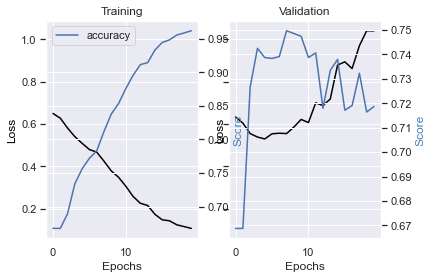

In [41]:
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()